### Importing required Modules and Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from nltk import pos_tag
import string, pickle, nltk
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import cross_val_score,train_test_split,KFold
from sklearn.metrics import (accuracy_score,confusion_matrix,classification_report,mean_squared_error,precision_score,
                             recall_score,roc_auc_score,f1_score,roc_curve,log_loss,r2_score,mean_absolute_error)

from sklearn.svm import SVR,SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.linear_model import Lasso,Ridge,ElasticNet,LinearRegression,SGDRegressor,SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier,GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing and visualize the data
mail= pd.read_csv('messages.csv')
mail.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [3]:
mail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [4]:
mail.shape

(2893, 3)

In [5]:
mail.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [6]:
# filling null values in dataset
mail['subject'].fillna(mail['subject'].mode()[0], inplace=True)

In [7]:
mail['description']=mail['subject']+mail['message']
mail.head()

,subject,message,label,description
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research centercontent...
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0,"sociolinguisticslang classification grimes , j..."
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...
3,risk,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...
4,request book information,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...


In [8]:
mail.drop(['subject','message'],axis=1,inplace=True)

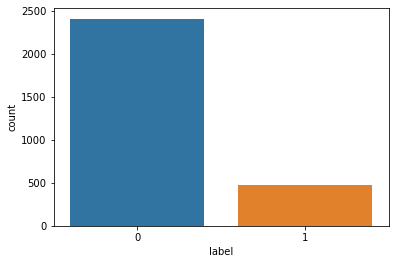

In [9]:
#Checking if training data is balanced or not
sns.countplot(mail['label'])

In [10]:
print ('counts','\n',mail.label.value_counts())

counts 
 0    2412
1     481
Name: label, dtype: int64


In [11]:
#checking the normalized counts
mail['label'].value_counts(normalize=True)

0    0.833737
1    0.166263
Name: label, dtype: float64

In [12]:
# adding length of the messages in mailing data
mail['length'] = mail['description'].apply(len)
mail.head(3)

,label,description,length
0,0,job posting - apple-iss research centercontent...,2895
1,0,"sociolinguisticslang classification grimes , j...",1816
2,0,query : letter frequencies for text identifica...,1485


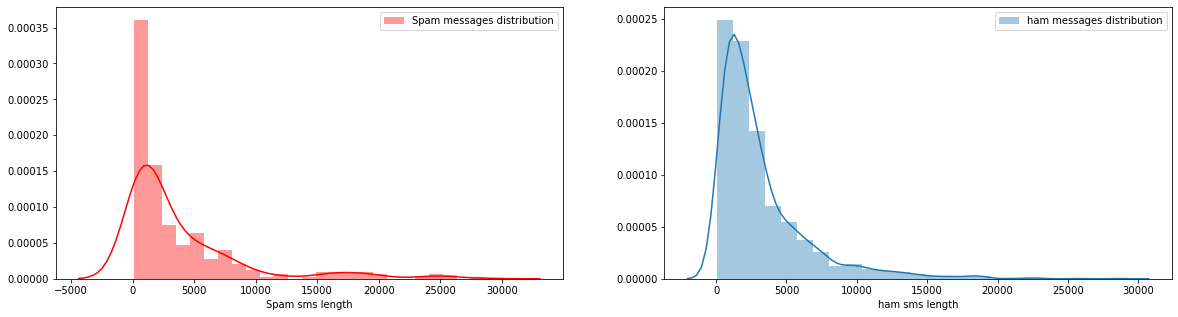

In [13]:
# checking distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (20,5))

sns.distplot(mail[mail['label']==1]['length'],bins=25,ax=ax[0],label='Spam messages distribution',color='r')

ax[0].set_xlabel('Spam sms length')
ax[0].legend()

sns.distplot(mail[mail['label']==0]['length'],bins=25,ax=ax[1],label='ham messages distribution')
ax[1].set_xlabel('ham sms length')
ax[1].legend()

plt.show()

#### Data cleaning

In [14]:
# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [15]:
# Let us create a function for cleaning the text data
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [16]:
# clean text data
mail["clean_desc"] = mail["description"].apply(lambda x: clean_text(x))

In [17]:
#adding length of reviews after cleaning the data
mail['clean_length'] = mail['clean_desc'].apply(len)
mail.head(3)

,label,description,length,clean_desc,clean_length
0,0,job posting - apple-iss research centercontent...,2895,job post apple-iss research centercontent leng...,1923
1,0,"sociolinguisticslang classification grimes , j...",1816,sociolinguisticslang classification grime jose...,1277
2,0,query : letter frequencies for text identifica...,1485,query letter frequency text identificationi po...,948


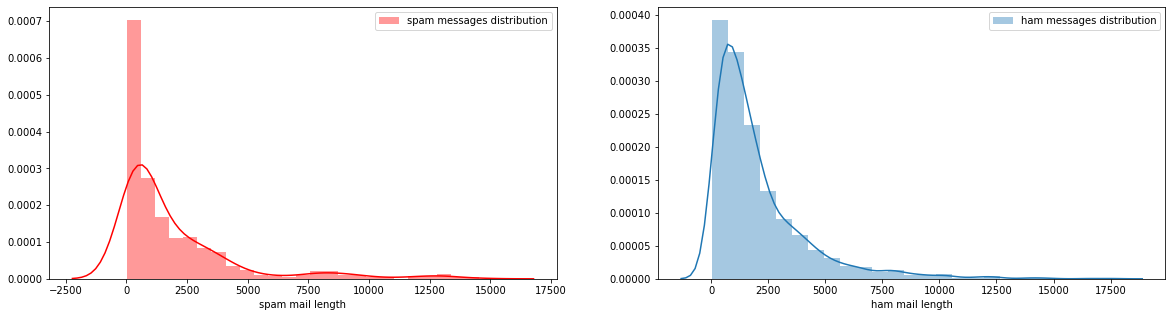

In [18]:
# review distribution after cleaning
f,ax = plt.subplots(1,2,figsize = (20,5))

sns.distplot(mail[mail['label']==1]['clean_length'],bins=25,ax=ax[0],label='spam messages distribution',color='r')

ax[0].set_xlabel('spam mail length')
ax[0].legend()

sns.distplot(mail[mail['label']==0]['clean_length'],bins=25,ax=ax[1],label='ham messages distribution')
ax[1].set_xlabel('ham mail length')
ax[1].legend()

plt.show()

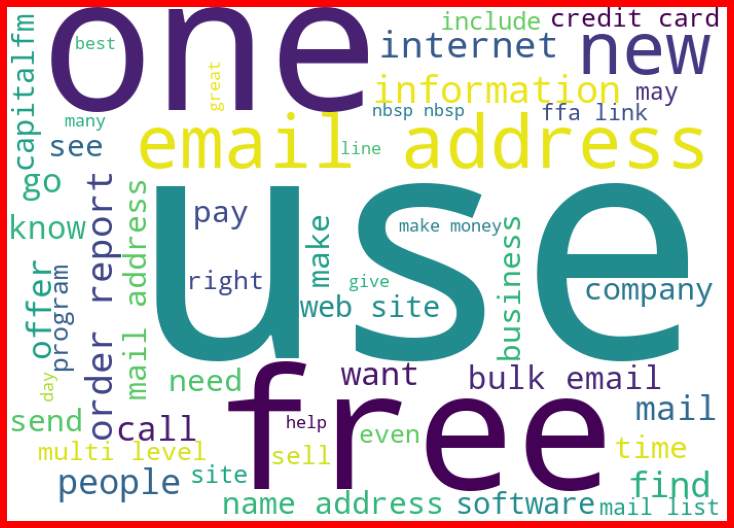

In [19]:
#frequent words used in postive reviews in mailing data with word cloud
spams = mail['clean_desc'][mail['label']==1]

spams_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spams_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

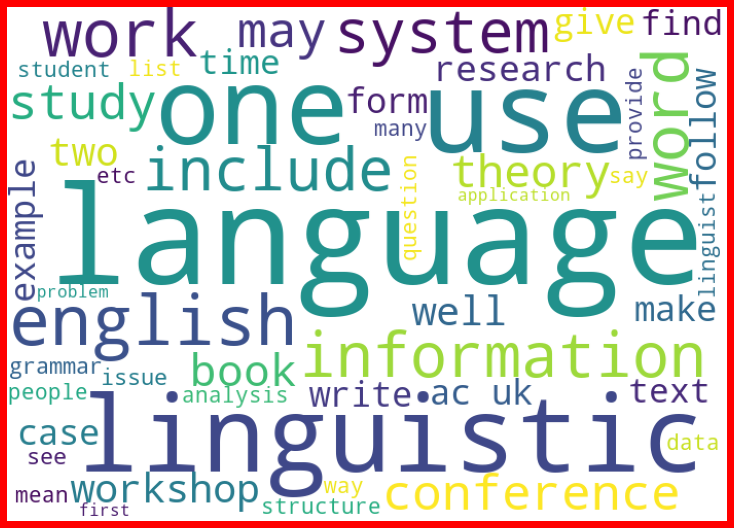

In [20]:
#frequent words used in postive reviews in mailing data with word cloud
hams = mail['clean_desc'][mail['label']==0]

hams_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(hams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(hams_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [21]:
#Converting training text into vectors using TF-IDF
tf_vec = TfidfVectorizer()
feature = tf_vec.fit_transform(mail['clean_desc'])
target = mail['label']

#### Checking performance of Different Models on training data

In [22]:
#creating models array with all the model
Models=[('SVC',SVC()),('GaussianNB',GaussianNB()),('SGDClassifier',SGDClassifier(random_state=10)),('LogisticRegression',LogisticRegression()),
        ('DecisionTreeClassifier',DecisionTreeClassifier(random_state=10)),('GradientBoostingClassifier',GradientBoostingClassifier()),
        ('LinearDiscriminantAnalysis',LinearDiscriminantAnalysis()),('RandomForestClassifier',RandomForestClassifier(random_state=10)),
        ('KNeighborsClassifier',KNeighborsClassifier()),('QuadraticDiscriminantAnalysis',QuadraticDiscriminantAnalysis())]

In [23]:
# loop to find out the cross_val_score of all the model in models array
Cross_val_score_array=[]
Standard_Deviation=[]
Model_array=[]
for name, model in Models:
    kf=KFold(n_splits=10,random_state=5)
    cscore=cross_val_score(model,feature, target, cv=kf, scoring='f1')
    Model_array.append(name)
    Cross_val_score_array.append(cscore.mean())
    Standard_Deviation.append(cscore.std())

In [24]:
# comparing the performances of all the model on crossval basis
model_cross_val_performance = pd.DataFrame({'Model': Model_array,'Cross val Acuracy': Cross_val_score_array,
                                            'Standard Deviation': Standard_Deviation})
model_cross_val_performance.sort_values(by='Cross val Acuracy', ascending=False)

,Model,Cross val Acuracy,Standard Deviation
2,SGDClassifier,0.971990,0.018454
8,KNeighborsClassifier,0.936296,0.038671
0,SVC,0.920698,0.031992
7,RandomForestClassifier,0.913426,0.034420
5,GradientBoostingClassifier,0.902847,0.032602
3,LogisticRegression,0.861081,0.049155
4,DecisionTreeClassifier,0.844943,0.050445
1,GaussianNB,NaN,NaN
6,LinearDiscriminantAnalysis,NaN,NaN
9,QuadraticDiscriminantAnalysis,NaN,NaN


#### Conclusion
On basis of Cross val Acuracy SGDClassifier model is performing the best

#### Training model and predecting

In [25]:
sgd=SGDClassifier()

train_x,test_x,train_y,test_y=train_test_split(feature, target,test_size=.2,random_state=81,stratify=target,shuffle=True)
sgd.fit(train_x,train_y)
pred=sgd.predict(test_x)

kf=KFold(n_splits=10,random_state=5)

score=cross_val_score(sgd,feature, target,cv=kf,scoring='accuracy')

print('Accuracy score of model is : ',accuracy_score(test_y,pred),'\n')
print('The mean of cross_val_score for the model is:',score.mean(),'\n')

print('Precision score of model is :',precision_score(test_y, pred),'\n')
print('Recall score of model is :',recall_score(test_y, pred),'\n')
print('F1_score score of model is :',f1_score(test_y, pred),'\n')

print('Confusion matrix for themodel is : \n',confusion_matrix(test_y,pred),'\n')
print('Classification report for the model is : \n',classification_report(test_y,pred),'\n')

Accuracy score of model is :  0.9861830742659758 

The mean of cross_val_score for the model is: 0.9899713637990694 

Precision score of model is : 1.0 

Recall score of model is : 0.9166666666666666 

F1_score score of model is : 0.9565217391304348 

Confusion matrix for themodel is : 
 [[483   0]
 [  8  88]] 

Classification report for the model is : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       483
           1       1.00      0.92      0.96        96

    accuracy                           0.99       579
   macro avg       0.99      0.96      0.97       579
weighted avg       0.99      0.99      0.99       579
 



In [26]:
#Lets us save this data a csv file
predicted_ham_and_spam = pd.DataFrame(pred, columns=['label'])
predicted_ham_and_spam.to_csv('ham_and_spam.csv')

In [27]:
# saving model 
save = open('saved_model.sav','wb')
pickle.dump(sgd,save)
save.close()